---

# Setup

##### Set Root Dir as CWD

In [1]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


##### Imports

In [2]:
import pickle

import numpy as np
import pandas as pd

import spacy

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor
from src.model import ReviewClassifier

# Load

In [3]:
path = "data/yelp/reviews/"

In [4]:
%%time
# Load dev set (10% of total data) as train
all_data = pd.read_pickle(path + "train.xz")

CPU times: total: 27.8 s
Wall time: 27.9 s


In [5]:
train, _ = train_test_split(all_data, train_size=300_000, stratify=all_data["stars"])
train, test = train_test_split(train, test_size=50_000, stratify=train["stars"])

In [6]:
train

,text,stars
6047922,Ahh... Big Daddy's. 24/7. Usually quite an int...,4
6615092,"I've been to this bar a few times, Kirsten is ...",5
703572,First time trying sushi. It was delicious. I h...,5
1627557,I don't find this pet store to be more particu...,3
5707458,Great sandwiches... and the price is right.......,4
...,...,...
15445,"The service was great. We went about 2pm, wasn...",5
6428025,"2-10-12,haven't been to Joe's in a long time, ...",1
1187667,Soooo good! I always get the veggie burger on ...,5
5630846,If you get there 30 min before the movie start...,5


In [7]:
test

,text,stars
69636,Its peaceful. Basically endless fields with t...,5
3690438,I was really suprised by how much i LOVED this...,5
6128050,I had to write this review because I crack up ...,4
4331260,Sat Sri Akal Yelpers!\n\nThis is my favorite i...,5
2856496,Wow. 99 Ranch in Tucson! I am so happy.\n\nThe...,5
...,...,...
2662662,Charged $20 for a shot of middle of the road b...,2
5163488,The Cajun Jambalaya Pasta was amazing! I highl...,5
5146467,"Atmosphere isn't too bad, but there's no reaso...",2
1255940,I ordered a burger from Uber EATS. Best burger...,5


##### Save Target

In [8]:
# Save reviews stars from 0-4
y_train = tf.convert_to_tensor(train["stars"].values - 1)
y_test = tf.convert_to_tensor(test["stars"].values - 1)

# Define Preprocess

In [9]:
batch_size = 4000
n_processes = 4

vocab_size = 20_000  # Size of vocabulary
maxlen = 200         # Number of words per review to consider

In [10]:
def preprocess(train, test, batch_size, n_processes, vocab_size, max_seq_length, 
               remove_stop=True, remove_punc=False, pad_punc=True, 
               lemmatize=True, alpha_only=False, split_digits=True, ner=True):
    """Preprocesses based on settings"""
    # Create preprocessor
    prep = ReviewPreprocessor(vocab_size, maxlen, 
                              remove_stop, remove_punc, pad_punc, 
                              lemmatize, alpha_only, split_digits, ner)
    
    X_train = prep.fit_transform(train["text"], batch_size, n_processes)
    X_test = prep.transform(test["text"], batch_size, n_processes)
    
    return X_train, X_test

# Define Model

In [11]:
# Hyperparameters
embed_dim = 32  # Attention output size
num_heads = 2   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 1.0e-2
dropout = 0.5

In [12]:
def create_model(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout):
    model = ReviewClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3), 
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Define Configurations

In [188]:
tr, fa = True, False

configs = {
    # type           sw  rp  pp  le  ao  sd  ne
    # ------------------------------------------
    "base":         (tr, fa, tr, tr, fa, tr, tr),
    "no_ner":       (tr, fa, tr, tr, fa, tr, fa),
    "no_digit":     (tr, fa, tr, tr, fa, fa, tr),
    "no_lemma":     (tr, fa, tr, fa, fa, tr, tr),
    "no_punc":      (tr, tr, tr, tr, fa, tr, tr),
    "alpha_only":   (tr, fa, tr, tr, tr, tr, tr),
    "with_stop":    (fa, fa, tr, tr, fa, tr, tr),
    "stop_no_ner":  (fa, fa, tr, tr, fa, tr, fa),
    "stop_no_lem":  (fa, fa, tr, fa, fa, tr, tr),
    "min_prep":     (fa, fa, tr, fa, fa, tr, fa),
}

# Run Experiment

> Tests and saves results for each preprocessing configuration.

In [14]:
%%time
epochs = 5

results = dict()
for config, params in configs.items():
    print(config)
    X_train, X_test = preprocess(train, test, batch_size, n_processes, vocab_size, maxlen, *params)
    model = create_model(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)
    
    results[config] = model.fit(X_train, y_train, batch_size=32, epochs=epochs,
                                validation_data=(X_test, y_test), verbose=1)
    
# Save results
final_res = {cfg: hist.history for cfg, hist in results.items()}
with open('experiments/results/prep_results.pickle', 'wb') as handle:
    pickle.dump(final_res, handle)

Epoch 1/5
7813/7813 [==============================] - 36s 4ms/step - loss: 0.9542 - accuracy: 0.6274 - val_loss: 0.7971 - val_accuracy: 0.6743
Epoch 2/5
7813/7813 [==============================] - 35s 4ms/step - loss: 0.8433 - accuracy: 0.6556 - val_loss: 0.7958 - val_accuracy: 0.6740
Epoch 3/5
7813/7813 [==============================] - 34s 4ms/step - loss: 0.8212 - accuracy: 0.6640 - val_loss: 0.8270 - val_accuracy: 0.6539
Epoch 4/5
7813/7813 [==============================] - 34s 4ms/step - loss: 0.8045 - accuracy: 0.6697 - val_loss: 0.8186 - val_accuracy: 0.6518
Epoch 5/5
7813/7813 [==============================] - 33s 4ms/step - loss: 0.7918 - accuracy: 0.6741 - val_loss: 0.8496 - val_accuracy: 0.6479
Epoch 1/5
7813/7813 [==============================] - 36s 4ms/step - loss: 0.9506 - accuracy: 0.6280 - val_loss: 0.7915 - val_accuracy: 0.6748
Epoch 2/5
7813/7813 [==============================] - 34s 4ms/step - loss: 0.8376 - accuracy: 0.6595 - val_loss: 0.7805 - val_accuracy:

INFO:tensorflow:Assets written to: ram://c68cea66-dced-42cd-b3b9-568a0dbc7e5c/assets


INFO:tensorflow:Assets written to: ram://c68cea66-dced-42cd-b3b9-568a0dbc7e5c/assets


INFO:tensorflow:Assets written to: ram://2310e74f-6e2f-4e8a-ae4a-8dc447551bb3/assets


INFO:tensorflow:Assets written to: ram://2310e74f-6e2f-4e8a-ae4a-8dc447551bb3/assets


INFO:tensorflow:Assets written to: ram://12025422-c53f-497f-b90d-1e896b4fb248/assets


INFO:tensorflow:Assets written to: ram://12025422-c53f-497f-b90d-1e896b4fb248/assets


INFO:tensorflow:Assets written to: ram://9287fffa-f39c-4e2a-b1b5-a4f4bd564987/assets


INFO:tensorflow:Assets written to: ram://9287fffa-f39c-4e2a-b1b5-a4f4bd564987/assets


INFO:tensorflow:Assets written to: ram://5552e0d1-e742-4703-a871-442299eb94f1/assets


INFO:tensorflow:Assets written to: ram://5552e0d1-e742-4703-a871-442299eb94f1/assets


INFO:tensorflow:Assets written to: ram://aa9f85d5-d1aa-4752-b27c-4be2de0e2c30/assets


INFO:tensorflow:Assets written to: ram://aa9f85d5-d1aa-4752-b27c-4be2de0e2c30/assets


INFO:tensorflow:Assets written to: ram://1f0db4a4-0c9f-4ac9-aab0-42556fa7d8fe/assets


INFO:tensorflow:Assets written to: ram://1f0db4a4-0c9f-4ac9-aab0-42556fa7d8fe/assets


CPU times: total: 52min 43s
Wall time: 1h 19min 25s


In [203]:
# Save results
final_res = {cfg: hist.history for cfg, hist in results.items()}
with open('experiments/results/prep_results.pickle', 'wb') as handle:
    pickle.dump(final_res, handle)

# Viz

In [192]:
val_losses = {cfg: hist.history["val_loss"] for cfg, hist in results.items()}
val_accs = {cfg: hist.history["val_accuracy"] for cfg, hist in results.items()}

##### Stats

In [193]:
losses = pd.DataFrame(val_losses).min()
accs = pd.DataFrame(val_accs).max()

df = pd.DataFrame(losses).reset_index()
df.columns = ["config", "min_loss"]
df["max_acc"] = accs.values
df

,config,min_loss,max_acc
0,base,0.795783,0.67426
1,no_ner,0.780513,0.67642
2,no_digit,0.798099,0.66708
3,no_lemma,0.782943,0.67700
4,no_punc,0.812246,0.66424
5,alpha_only,0.806292,0.66902
6,with_stop,0.776732,0.67772
7,stop_no_ner,0.792534,0.67378
8,stop_no_lem,0.773775,0.68458
9,min_prep,0.780139,0.67652


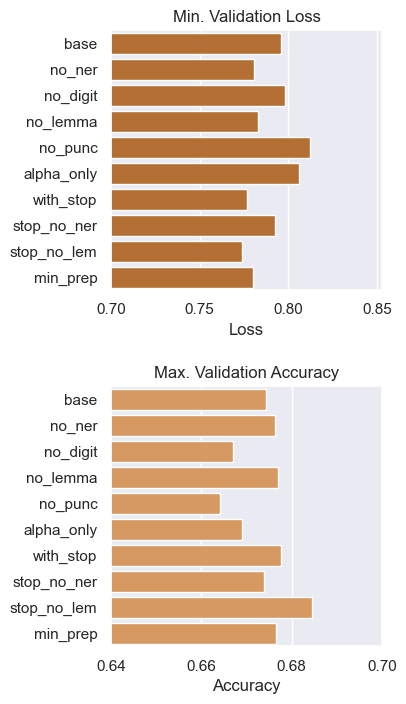

In [194]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(3.5, 8), dpi=100)

sns.barplot(
    data=df,
    x="min_loss",
    y="config",
    ax=axes[0],
    color="#CA6F1E"
)
axes[0].set_title("Min. Validation Loss")
axes[0].set_xlim(0.7)
axes[0].set_xlabel("Loss")
axes[0].set_ylabel("")

sns.barplot(
    data=df,
    x="max_acc",
    y="config",
    ax=axes[1],
    color="#EB984E",
)
axes[1].set_title("Max. Validation Accuracy")
axes[1].set_xlim(0.64, 0.7)
axes[1].set_xlabel("Accuracy")
axes[1].set_ylabel("")

plt.subplots_adjust(hspace=0.37)

plt.show()